In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [47]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [4]:
from soundsig.sound import BioSound 

### Collect data

In [5]:
DATASET_ID = 'batsong_isolate_segmented'

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'isolation_r2.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/batsong_isolate_segmented/isolation_r2.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,0.2140,0.3065,0,0,121220031934346505,"[-0.01634356, -0.016108407, -0.01484951, -0.01...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.3165,0.3360,0,0,121220031934346505,"[-0.04675521, -0.054559425, -0.07107724, -0.05...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019517358, -3.8..."
2,0.3375,0.3590,0,0,121220031934346505,"[0.04236861, 0.014425384, -0.026170516, -0.043...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.005857594, -0.001..."


## make projections

### UMAP

In [9]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [19]:
top_indvs = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.indv.values == i)] for i in syllable_df.indv.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:12]
    .T
)
top_indvs

,0,111,211,220,216,221,230,115,207,108,202,231
0,18803,1887,1840,1141,861,601,596,594,577,526,421,370


In [20]:
subset_df = syllable_df[syllable_df.indv.isin(top_indvs.columns[1:])]

In [36]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

cuml_umap = cumlUMAP()#min_dist=0.25)
z = cuml_umap.fit_transform(specs_flattened)

subset_df['umap'] = list(z)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  import sys
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
len(subset_df)

9414

In [38]:
nex = len(subset_df)

In [39]:
from avgn.visualization.projections import scatter_spec

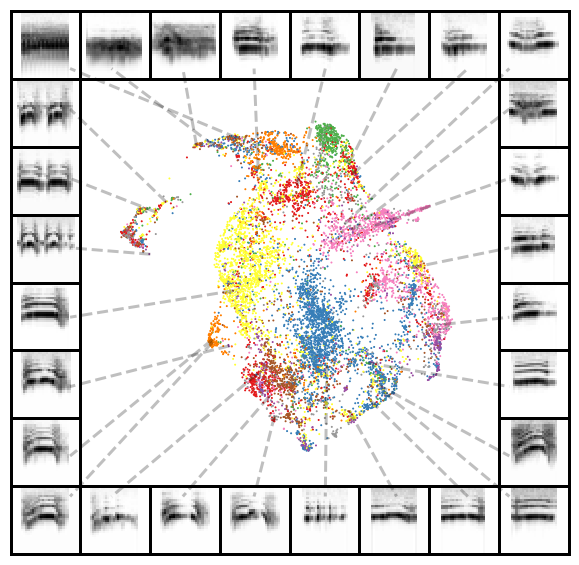

In [49]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'isolation_bat_umap', dpi=300, save_jpg=True)

### tsne

In [27]:
from sklearn import manifold

In [29]:
tsne = manifold.TSNE(n_components=2, init='pca',
                                 random_state=0)

In [31]:
z_tsne = tsne.fit_transform(specs_flattened)

In [44]:
subset_df['tsne'] = list(z_tsne)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


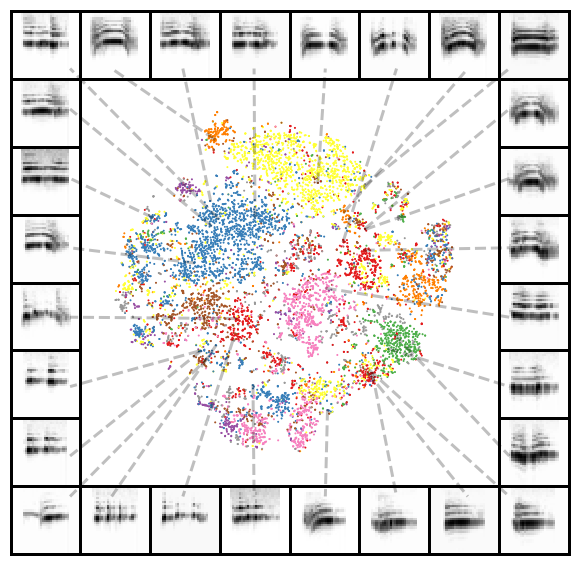

In [51]:
nex = -1
scatter_spec(
    z_tsne,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'isolation_bat_tSNE', dpi=300, save_jpg=True)

### PCA

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(specs_flattened)

In [45]:
subset_df['PCA'] = list(z_pca)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


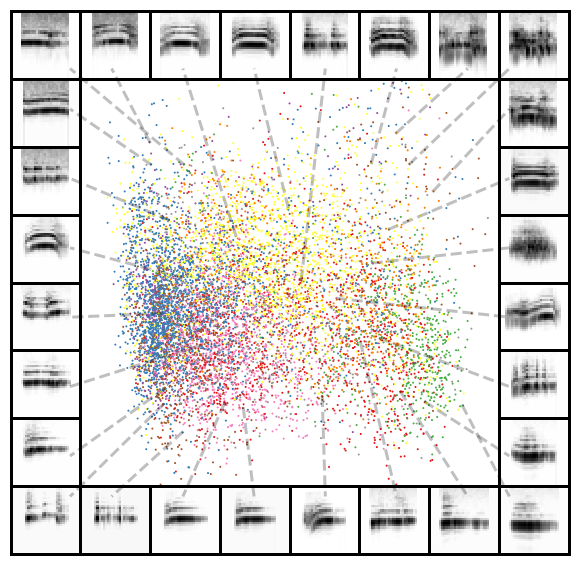

In [52]:
nex = -1
scatter_spec(
    z_pca,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'isolation_bat_PCA', dpi=300, save_jpg=True)

### Multidimensional scaling

In [41]:
mds = manifold.MDS(2, max_iter=100, n_init=1)

In [42]:
z_mds = mds.fit_transform(specs_flattened)

In [46]:
subset_df['mds'] = list(z_mds)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


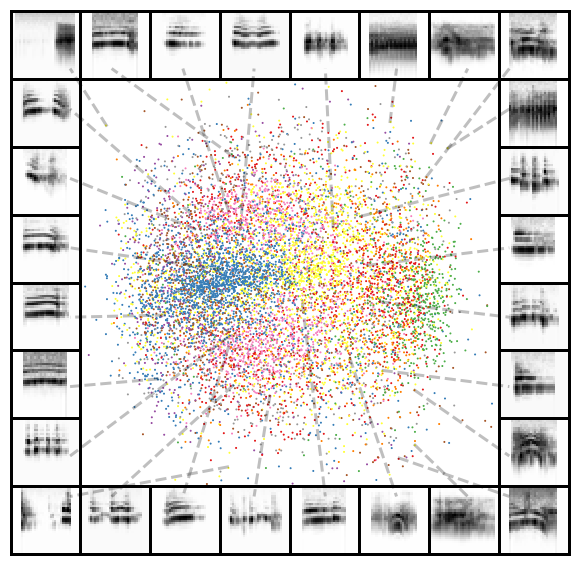

In [53]:
nex = -1
scatter_spec(
    z_mds,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'isolation_bat_MDS', dpi=300, save_jpg=True)

### non-metric multidimensional scaling

In [54]:
nmds = manifold.MDS(2, max_iter=100, n_init=1, metric=False)

In [56]:
z_nmds =nmds.fit_transform(specs_flattened)

In [57]:
subset_df['nmds'] = list(z_nmds)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


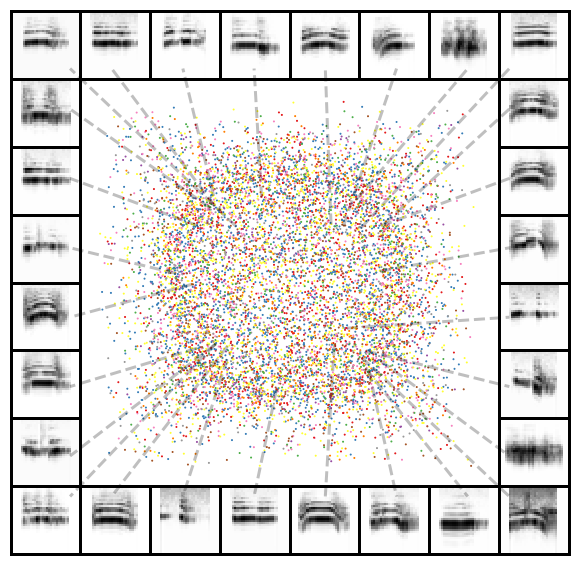

In [58]:
nex = -1
scatter_spec(
    z_nmds,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': subset_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'isolation_bat_NMDS', dpi=300, save_jpg=True)

In [48]:
subset_df.to_pickle(DATA_DIR / 'syllable_dfs' / DATASET_ID / 'isolation_bat_projections.pickle')